# WOLO - compute regression and classification metrics
This script takes the _test_data_pred_results.csv_ files produced during network fitting and evaluation on test-data as an input and computes the desired output metrics and plots:

- MAPE_true
- MAPE_ideal
- MAPE_class
- classification accuracy
- confusion matrices
- class-wise scores
- coefficient of variation

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# call the following once to produce resized plots across the notebook
plt.show()
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 100

input_file = "example_data/DETECT_5_class.csv"

In [2]:
file = open(input_file, "r")
data = list(csv.reader(file, delimiter=","))
file.close()

if input_file.split("/")[-1].split("_")[0] == "DETECT":
    DETECTION = True
else:
    DETECTION = False

In [3]:
def find_class(array, value):
    array_np = np.asarray(array)
    idx = (np.abs(array_np - value)).argmin()
    nearest_class = array_np[idx]
    pred_class = array.index(nearest_class)
    return pred_class

In [4]:
print("Retrieving the following info from the input file:", data[0][1:6])
file_names = [row[1] for row in data[1:]]

five_class = [0.0013, 0.0030, 0.0068, 0.0154, 0.0351]
twenty_class = [0.0010, 0.0012, 0.0015, 0.0019, 0.0023, 0.0028,
                0.0034, 0.0042, 0.0052, 0.0064, 0.0078, 0.0096,
                0.0118, 0.0145, 0.0179, 0.0219, 0.0270, 0.0331,
                0.0407, 0.0500]
scaled_20 = [int(x * 10001) for x in twenty_class]

if len(data[0]) > 11:
    CLASS_LIST = twenty_class
elif len(data[0]) == 11:
    CLASS_LIST = five_class
else: 
    CLASS_LIST = twenty_class # use classification approach of 20 class list for displaying regressor outputs

if len(data[0]) < 6 and not DETECTION: # regressors have fewer lines as the output activations aren't relevant
    true_classes = [scaled_20.index(int(x.split("/")[1])) for x in [row[1] for row in data[1:]]]
    pred_classes = [find_class(twenty_class, float(x)) for x in [row[3] for row in data[1:]]]
    true_weight = [float(x) for x in [row[2] for row in data[1:]]]
    pred_weight = [float(x) for x in [row[3] for row in data[1:]]]
else:
    true_classes = [int(x) for x in [row[2] for row in data[1:]]]
    pred_classes = [int(x) for x in [row[3] for row in data[1:]]]
    true_weight = [float(x) for x in [row[4] for row in data[1:]]]
    pred_weight = [float(x) for x in [row[5] for row in data[1:]]]
    
if DETECTION:
    if len(np.unique(true_classes)) == 5:
        CLASS_LIST = five_class
    else:
        CLASS_LIST = twenty_class
    
    print(len(np.unique(true_classes)), "class detection data found!")

Retrieving the following info from the input file: ['file', 'gt_class', 'pred_class', 'gt', 'pred']
20 class detection data found!


### Compute overall MAPE and accuracy scores
across the full test dataset

In [5]:
def goAPE(y_true,y_pred,CLASS_LIST=None,gt_v_class=False):
    """
    y_true : gt label vector of lenght n
    y_pred : prediction label vector of length n
    CLASS_LIST : lookup table of class centres (optional)
    return : MAPE, STDAPE
    """
    assert len(y_true) == len(y_pred), "Mismatch between input vectors"
    if CLASS_LIST is None:
        APE = [np.abs((x[0] - x[1])/x[0]) for x in zip(y_true,y_pred) if x[1] != -1]
    elif gt_v_class:
        APE = [np.abs((x[0] - CLASS_LIST[x[1]])/x[0]) for x in zip(y_true,y_pred) if x[1] != -1]
    else:
        APE = [np.abs((CLASS_LIST[x[0]] - CLASS_LIST[x[1]])/CLASS_LIST[x[0]]) for x in zip(y_true,y_pred) if x[1] != -1]
    
    MAPE = 100 * np.mean(APE)
    STDAPE = 100 * np.std(APE)
    
    return MAPE, STDAPE

In [6]:
MAPE_true, STDAPE_true = goAPE(y_true=true_weight,
                               y_pred=pred_weight)
print("MAPE_true  : ", round(MAPE_true,2), "  STDAPE_true : ", round(STDAPE_true,2))

if CLASS_LIST is not None:
    MAPE_ideal, STDAPE_ideal = goAPE(y_true=true_weight,
                                     y_pred=true_classes,
                                     CLASS_LIST=CLASS_LIST,
                                     gt_v_class=True)
    print("MAPE_ideal : ", round(MAPE_ideal,2), "  STDAPE_ideal : ", round(STDAPE_ideal,2))

    MAPE_class, STDAPE_class = goAPE(y_true=true_classes,
                                     y_pred=pred_classes,
                                     CLASS_LIST=CLASS_LIST)
    print("MAPE_class : ", round(MAPE_class,2), "  STDAPE_class : ", round(STDAPE_class,2))
    
    accuracy = metrics.accuracy_score(y_true=true_classes,
                                      y_pred=pred_classes)
    
    print("Classification accuracy :", round(accuracy,4))

MAPE_true  :  93.06   STDAPE_true :  381.66
MAPE_ideal :  6.09   STDAPE_ideal :  16.11
MAPE_class :  88.79   STDAPE_class :  378.97
Classification accuracy : 0.5201


### Produce confusion matrices

In [7]:
if DETECTION:
    true_classes_cleaned = [x[0] for x in zip(true_classes,pred_classes) if x[1] != -1]
    pred_classes_cleaned = [x for x in pred_classes if x != -1]
    file_names_cleaned = [x[0] for x in zip(file_names,pred_classes) if x[1] != -1]
    true_weight_cleaned = [x[0] for x in zip(true_weight,pred_classes) if x[1] != -1]
    pred_weight_cleaned = [x[0] for x in zip(pred_weight,pred_classes) if x[1] != -1]
    
    true_classes = true_classes_cleaned
    pred_classes = pred_classes_cleaned
    file_names = file_names_cleaned
    true_weight = true_weight_cleaned
    pred_weight = pred_weight_cleaned

y_actu = pd.Series([CLASS_LIST[x] for x in true_classes], name='True class')
y_pred = pd.Series([CLASS_LIST[x] for x in pred_classes], name='Predicted class')
df_confusion = pd.crosstab(y_actu, y_pred)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")
df_conf_norm

Predicted class,0.0010,0.0012,0.0015,0.0019,0.0023,0.0028,0.0034,0.0042,0.0052,0.0064,0.0078,0.0096,0.0118,0.0145,0.0179,0.0219,0.0270,0.0331,0.0407,0.0500
True class,,,,,,,,,,,,,,,,,,,,
0.0010,0.414857,0.062594,0.023734,0.014691,0.139641,0.008175,0.003396,0.017732,0.222415,0.014651,0.000000,0.005371,0.002725,0.000000,0.000000,0.000000,0.001422,0.036806,0.016626,0.015165
0.0012,0.135512,0.522018,0.000575,0.113096,0.039128,0.005924,0.000088,0.012424,0.001415,0.009506,0.000000,0.021266,0.000133,0.004775,0.000088,0.000177,0.003360,0.058140,0.021178,0.051198
0.0015,0.000000,0.000000,0.874144,0.000000,0.016099,0.000000,0.000000,0.093223,0.000000,0.000096,0.000000,0.010267,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006170,0.000000
0.0019,0.033586,0.013508,0.006352,0.526869,0.076920,0.000365,0.003797,0.006790,0.000000,0.006608,0.000073,0.116859,0.025299,0.000000,0.033769,0.000402,0.001789,0.136463,0.008360,0.002190
0.0023,0.040082,0.019433,0.005248,0.200487,0.570353,0.079328,0.005856,0.015972,0.001749,0.005894,0.000000,0.000494,0.005172,0.023083,0.000000,0.006655,0.000000,0.006009,0.003803,0.010382
0.0028,0.011107,0.034625,0.000000,0.087340,0.072000,0.620102,0.063099,0.003184,0.006621,0.000868,0.003329,0.000000,0.000977,0.039111,0.007851,0.002714,0.001592,0.014074,0.023952,0.007453
0.0034,0.000000,0.007550,0.000000,0.028670,0.021796,0.173054,0.550110,0.047831,0.084301,0.005556,0.000000,0.000000,0.019197,0.008049,0.040672,0.004523,0.003740,0.000000,0.002279,0.002671
0.0042,0.000037,0.001006,0.020860,0.000000,0.015421,0.009499,0.015645,0.609998,0.016911,0.000745,0.019221,0.049132,0.001527,0.160024,0.000447,0.076846,0.000000,0.000000,0.000000,0.002682
0.0052,0.023943,0.002799,0.000000,0.000000,0.000000,0.075291,0.000405,0.130065,0.507956,0.026153,0.007772,0.000000,0.000000,0.162774,0.000037,0.048622,0.007735,0.000000,0.006446,0.000000


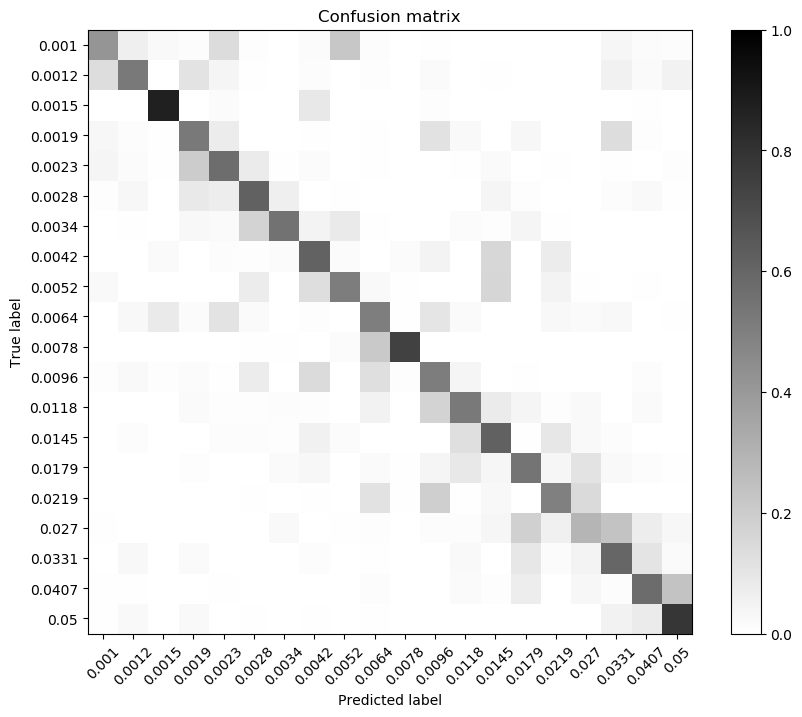

In [8]:
confusion_matrix = metrics.confusion_matrix(true_classes, pred_classes, normalize="true")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = CLASS_LIST)

cm_display.plot(cmap=plt.cm.gray_r, 
                include_values=False, #set to true to display individual values
                xticks_rotation=45)

# update colour scale to enforce displaying normalised values between 0 and 1
for im in plt.gca().get_images():
    im.set_clim(vmin=0,vmax=1)  
    
plt.title("Confusion matrix")
plt.show()

### Compute class wise scores 
and **prediction stability** in terms of the **average coefficient of variation** across continuous samples containing the same individual

In [9]:
data_comb = zip(file_names,true_classes,pred_classes,true_weight,pred_weight)

prev_class_temp = true_classes[0]
ind_list = {}

class_wise_scores = []

class_wise_elements_gt_cl = []
class_wise_elements_p_cl = []
class_wise_elements_gt = []
class_wise_elements_p = []

for f,gt_cl,p_cl,gt,p in data_comb:    
    file_components = f.split("/")
    class_temp = gt_cl
    # cut away the frame number so individuals have consistent names
    vid = "_".join(file_components[2].split("_")[0:-2]) + "_" + file_components[2].split("_")[-1]
    
    if vid not in ind_list:
        ind_list[vid] = []
    
    """
    # use the following instead of line below, when extracting error stability instead of prediction stability
    if CLASS_LIST is not None:
        APE_temp = np.abs((CLASS_LIST[gt_cl] - CLASS_LIST[p_cl])/CLASS_LIST[gt_cl])
    else:
        APE_temp = np.abs((gt - p)/gt)
        
    ind_list[vid].append(APE_temp)
    """    
    
    ind_list[vid].append(p)
    
    
    
    if class_temp != prev_class_temp or f == file_names[-1]:
        if f == file_names[-1]:
            # in case this is the last element, add the final line before computing scores
            class_wise_elements_gt_cl.append(gt_cl)
            class_wise_elements_p_cl.append(p_cl)
            class_wise_elements_gt.append(gt)
            class_wise_elements_p.append(p)
            
        print("\nCLASS : ", CLASS_LIST[prev_class_temp])

        MAPE_true, STDAPE_true = goAPE(y_true=class_wise_elements_gt,
                                       y_pred=class_wise_elements_p)
        print("MAPE_true  : ", round(MAPE_true,2), "  STDAPE_true : ", round(STDAPE_true,2))

        MAPE_ideal, STDAPE_ideal = goAPE(y_true=class_wise_elements_gt,
                                         y_pred=class_wise_elements_gt_cl,
                                         CLASS_LIST=CLASS_LIST,
                                         gt_v_class=True)
        print("MAPE_ideal : ", round(MAPE_ideal,2), "  STDAPE_ideal : ", round(STDAPE_ideal,2))

        MAPE_class, STDAPE_class = goAPE(y_true=class_wise_elements_gt_cl,
                                         y_pred=class_wise_elements_p_cl,
                                         CLASS_LIST=CLASS_LIST)
        print("MAPE_class : ", round(MAPE_class,2), "  STDAPE_class : ", round(STDAPE_class,2))

        accuracy = metrics.accuracy_score(y_true=class_wise_elements_gt_cl,
                                          y_pred=class_wise_elements_p_cl)

        print("Classification accuracy :", round(accuracy,4))

        class_wise_scores.append([prev_class_temp,
                                  MAPE_true, STDAPE_true,
                                  MAPE_ideal, STDAPE_ideal,
                                  MAPE_class, STDAPE_class,
                                  accuracy])
        
        prev_class_temp = class_temp
        class_wise_elements_gt_cl = []
        class_wise_elements_p_cl = []
        class_wise_elements_gt = []
        class_wise_elements_p = []
    
    class_wise_elements_gt_cl.append(gt_cl)
    class_wise_elements_p_cl.append(p_cl)
    class_wise_elements_gt.append(gt)
    class_wise_elements_p.append(p)
    
class_wise_scores = np.array(class_wise_scores)


CLASS :  0.001
MAPE_true  :  463.39   STDAPE_true :  985.12
MAPE_ideal :  31.29   STDAPE_ideal :  49.1
MAPE_class :  400.92   STDAPE_class :  953.82
Classification accuracy : 0.4149

CLASS :  0.0012
MAPE_true  :  475.99   STDAPE_true :  1118.51
MAPE_ideal :  3.62   STDAPE_ideal :  3.84
MAPE_class :  481.38   STDAPE_class :  1136.44
Classification accuracy : 0.522

CLASS :  0.0015
MAPE_true  :  49.56   STDAPE_true :  231.32
MAPE_ideal :  7.52   STDAPE_ideal :  1.74
MAPE_class :  39.34   STDAPE_class :  216.01
Classification accuracy : 0.8741

CLASS :  0.0019
MAPE_true  :  341.1   STDAPE_true :  588.01
MAPE_ideal :  3.08   STDAPE_ideal :  2.43
MAPE_class :  345.04   STDAPE_class :  593.32
Classification accuracy : 0.5269

CLASS :  0.0023
MAPE_true  :  69.42   STDAPE_true :  272.21
MAPE_ideal :  1.83   STDAPE_ideal :  3.36
MAPE_class :  67.59   STDAPE_class :  272.64
Classification accuracy : 0.5704

CLASS :  0.0028
MAPE_true  :  93.25   STDAPE_true :  281.44
MAPE_ideal :  3.31   STDAPE_

In [10]:
coeff_var_ind = []

for key, value in ind_list.items() :
    coeff_var_ind.append(np.std(value)/np.mean(value))
    
print("Average coefficient of variation across repeated predictions: ", round(np.mean(coeff_var_ind),4))

Average coefficient of variation across repeated predictions:  0.541


### class wise score visualisation
Finally, plot the resulting class-wise MAPE (comparing prediction to ground truth, regardless of inference method) and class-wise accuracy

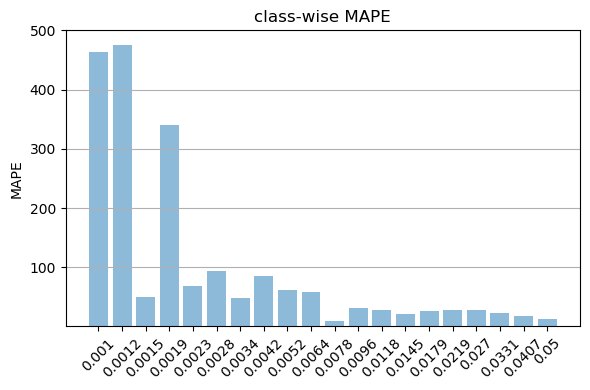

In [11]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
ax.bar(np.arange(len(CLASS_LIST)), class_wise_scores[:,1], 
       #yerr=class_wise_scores[:,2], 
       align='center', 
       alpha=0.5, 
       ecolor='black', capsize=10)

ax.set_ylabel('MAPE')
ax.set_xticks(np.arange(len(CLASS_LIST)))
ax.set_xticklabels(CLASS_LIST, rotation=45)
ax.set_title('class-wise MAPE')
ax.yaxis.grid(True)
#ax.set_yscale('log')
ax.set_ylim(1,500)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()

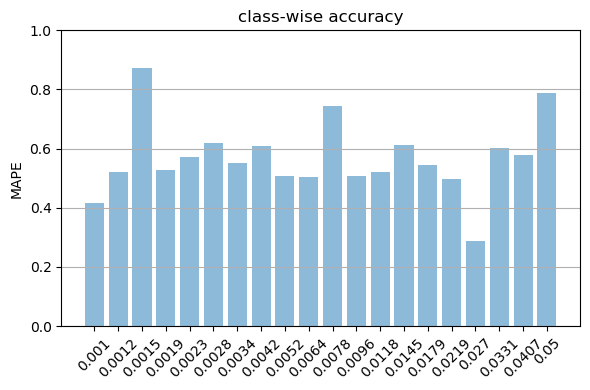

In [12]:
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()
ax.bar(np.arange(len(CLASS_LIST)), class_wise_scores[:,-1], 
       #yerr=class_wise_scores[:,2], 
       align='center', 
       alpha=0.5, 
       ecolor='black', capsize=10)

ax.set_ylabel('MAPE')
ax.set_xticks(np.arange(len(CLASS_LIST)))
ax.set_xticklabels(CLASS_LIST, rotation=45)
ax.set_title('class-wise accuracy')
ax.yaxis.grid(True)
ax.set_ylim(0,1)

# Save the figure and show
plt.tight_layout()
#plt.savefig('bar_plot_with_error_bars.png')
plt.show()